### imports

In [1]:
import pyspark
import pyspark.sql.functions as F
from pyspark.sql.functions import *
from pyspark.sql.types import (
    StructType, StructField,
    StringType, LongType, DoubleType, TimestampType
)
import pandas as pd
import numpy as np
import os
import sys
import math
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
import matplotlib.pyplot as plt
import pyarrow
import seaborn as sns

## 1. PySpark

In [2]:
# Inicializa a sessão Spark
spark = SparkSession.builder.appName("PMBD - Collaborative Filtering") \
    .config("spark.sql.shuffle.partitions", "400") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.cores", "8") \
    .config("spark.executor.memoryOverhead", "4g") \
    .config("spark.executor.instances", "10") \
    .getOrCreate()

spark.sparkContext.setLogLevel("INFO")  # Pode ser ajustado para "INFO" durante o desenvolvimento

In [3]:
print(spark.sparkContext._jsc.sc().isStopped())  # False -> tudo bem; True -> Spark está desligado

False


## 2. Tempo Gráficos

### 2.1 Schema do dataframe 

In [4]:
schema = StructType([
    StructField("0.001", DoubleType(), True),
    StructField("0.0015", DoubleType(), True),
    StructField("0.002", DoubleType(), True),
    StructField("0.003", DoubleType(), True),
    StructField("0.005", DoubleType(), True),
    StructField("0.007", DoubleType(), True),
    StructField("0.01", DoubleType(), True),
    StructField("0.015", DoubleType(), True),
    StructField("0.02", DoubleType(), True),
    StructField("0.035", DoubleType(), True),
    StructField("0.05", DoubleType(), True),
    StructField("0.075", DoubleType(), True),
    StructField("0.1", DoubleType(), True),
    StructField("0.15", DoubleType(), True),
    StructField("0.2", DoubleType(), True),
    StructField("0.35", DoubleType(), True),
    StructField("0.5", DoubleType(), True),
    StructField("0.75", DoubleType(), True),
    StructField("1.0", DoubleType(), True),
    StructField("__index_level_0__", StringType(), True)
])

time = spark.read.parquet('durations_df.parquet', schema=schema)

In [5]:
time.show()

+-----------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+
|            0.001|           0.0015|             0.002|             0.003|             0.005|            0.007|              0.01|             0.015|              0.02|             0.035|              0.05|             0.075|               0.1|              0.15|               0.2|              0.35|               0.5|              0.75|              1.0|__index_level_0__|
+-----------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-

### 2.2. Preparar os dados para visualização com matplotlib/pandas

In [6]:
time_pd = time.toPandas()
time_pd = time_pd.set_index('__index_level_0__').T  # Transpor para que cada linha seja uma proporção
time_pd.index = time_pd.index.astype(float)         # Garantir que os índices são numéricos
time_pd.sort_index(inplace=True)                    # Ordenar as proporções
time_pd

__index_level_0__,datajoining,eda,dataprep,clustering
0.0010,53.440968,29.033221,8.790941,5.100560
0.0015,52.983942,27.943781,8.472898,5.333444
0.0020,57.702124,30.033543,8.620201,5.695145
0.0030,54.932468,34.786100,8.440993,6.872297
0.0050,53.204107,38.415286,9.242718,8.352294
0.0070,54.641473,37.268356,9.766967,9.747213
0.0100,54.545014,37.559387,10.634158,11.696807
0.0150,54.662516,38.945915,11.226106,13.020688
0.0200,55.564603,40.255286,11.562761,15.361461
0.0350,57.851368,44.380112,12.859218,17.008600


### Extra - Atualização do dataset da complexidade

In [7]:
clusterSize = [66504,
 97837,
 128330,
 185320,
 289040,
 382217,
 506490,
 683834,
 834416,
 1188598,
 1454590,
 1789831,
 2046639,
 2428005,
 2710485,
 3271121,
 3628672,
 4027167,
 4299931
 ]

time_pd["UserDataSet"] = clusterSize
time_pd

__index_level_0__,datajoining,eda,dataprep,clustering,UserDataSet
0.0010,53.440968,29.033221,8.790941,5.100560,66504
0.0015,52.983942,27.943781,8.472898,5.333444,97837
0.0020,57.702124,30.033543,8.620201,5.695145,128330
0.0030,54.932468,34.786100,8.440993,6.872297,185320
0.0050,53.204107,38.415286,9.242718,8.352294,289040
0.0070,54.641473,37.268356,9.766967,9.747213,382217
0.0100,54.545014,37.559387,10.634158,11.696807,506490
0.0150,54.662516,38.945915,11.226106,13.020688,683834
0.0200,55.564603,40.255286,11.562761,15.361461,834416
0.0350,57.851368,44.380112,12.859218,17.008600,1188598


In [8]:
datajoin_sizes = [
    109951,
    164926,
    219901,
    329852,
    549754,
    769655,
    1099507,
    1649261,
    2199015,
    3848276,
    5497537,
    8246306,
    10995073,
    16492610,
    21990146,
    38482761,
    54975375,
    82463056,
    109950743
]


time_pd["EcommerceDataSet"] = datajoin_sizes
time_pd

__index_level_0__,datajoining,eda,dataprep,clustering,UserDataSet,EcommerceDataSet
0.0010,53.440968,29.033221,8.790941,5.100560,66504,109951
0.0015,52.983942,27.943781,8.472898,5.333444,97837,164926
0.0020,57.702124,30.033543,8.620201,5.695145,128330,219901
0.0030,54.932468,34.786100,8.440993,6.872297,185320,329852
0.0050,53.204107,38.415286,9.242718,8.352294,289040,549754
0.0070,54.641473,37.268356,9.766967,9.747213,382217,769655
0.0100,54.545014,37.559387,10.634158,11.696807,506490,1099507
0.0150,54.662516,38.945915,11.226106,13.020688,683834,1649261
0.0200,55.564603,40.255286,11.562761,15.361461,834416,2199015
0.0350,57.851368,44.380112,12.859218,17.008600,1188598,3848276


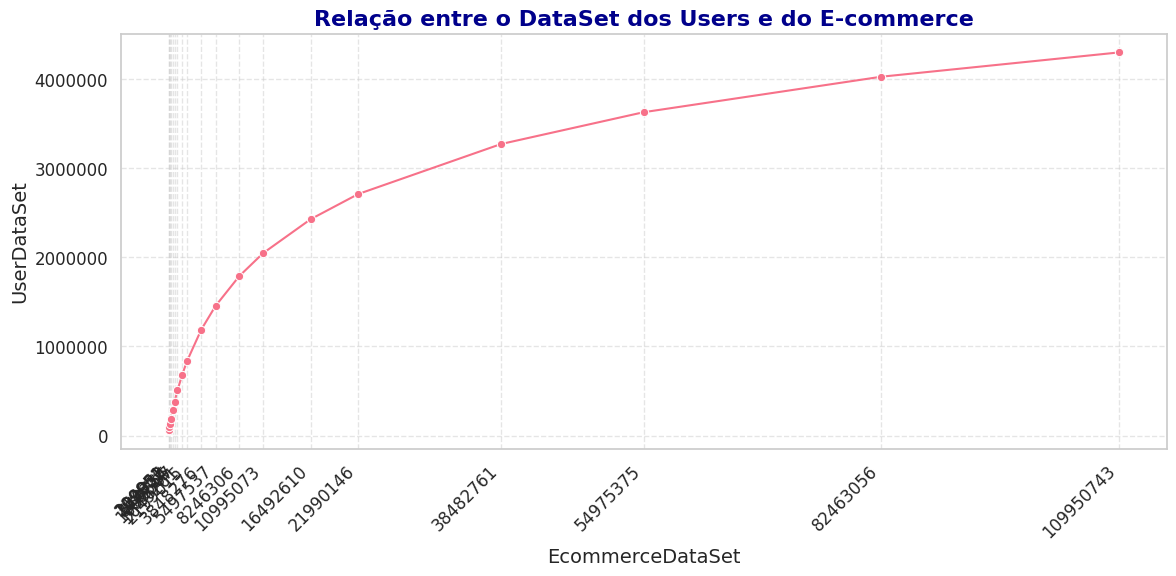

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definir o estilo do seaborn
sns.set(style='whitegrid', palette='deep', font_scale=1.2)

# Cores (caso queiras usar mais de uma linha, por exemplo)
cores = sns.color_palette('husl', n_colors=1)

# Preparar os dados do eixo X (EcommerceDataSet) e Y (UserDataSet)
x = time_pd["EcommerceDataSet"]
y = time_pd["UserDataSet"]

# Criar o gráfico
plt.figure(figsize=(12, 6))
sns.lineplot(x=x, y=y, marker='o', color=cores[0])

# Adicionar título e rótulos aos eixos
plt.title('Relação entre o DataSet dos Users e do E-commerce', fontsize=16, weight='bold', color='darkblue')
plt.xlabel('EcommerceDataSet', fontsize=14)
plt.ylabel('UserDataSet', fontsize=14)

# Ajustar os xticks para garantir uma visualização limpa
xticks_labels = [f'{x:.4f}' for x in time_pd["EcommerceDataSet"]]

# Definir os xticks com as labels
plt.xticks(ticks=x, labels=xticks_labels, rotation=45, ha='right')

# Acessar o formatter dos eixos e remover a notação científica
plt.gca().tick_params(axis='both', which='both', labelsize=12)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: '{:.0f}'.format(val)))  # Ajustar o eixo X
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda val, pos: '{:.0f}'.format(val)))  # Ajustar o eixo Y

# Ajustar o layout e mostrar o gráfico
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### 2.3. Gráficos

#### A. Gráfico de cada fase separada

In [10]:
time_pd.columns

Index(['datajoining', 'eda', 'dataprep', 'clustering', 'UserDataSet',
       'EcommerceDataSet'],
      dtype='object', name='__index_level_0__')

datajoining


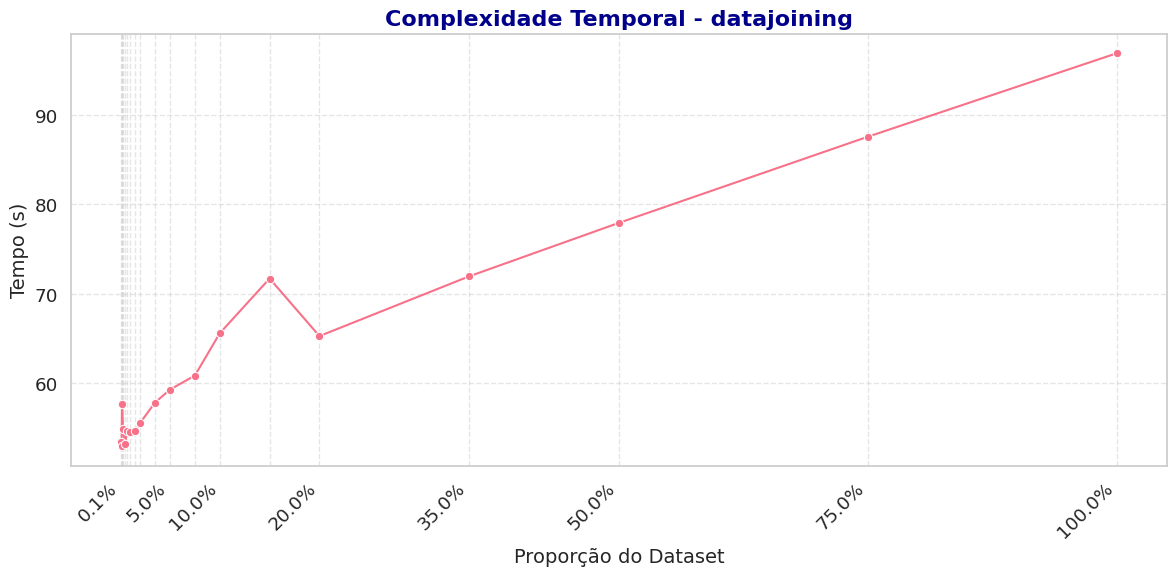

eda


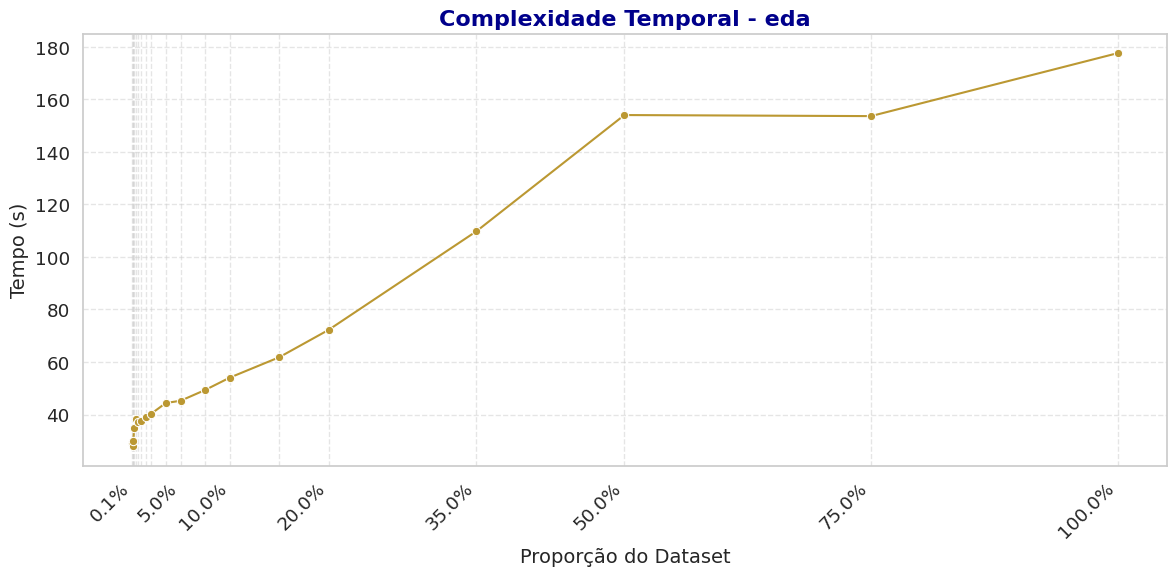

dataprep


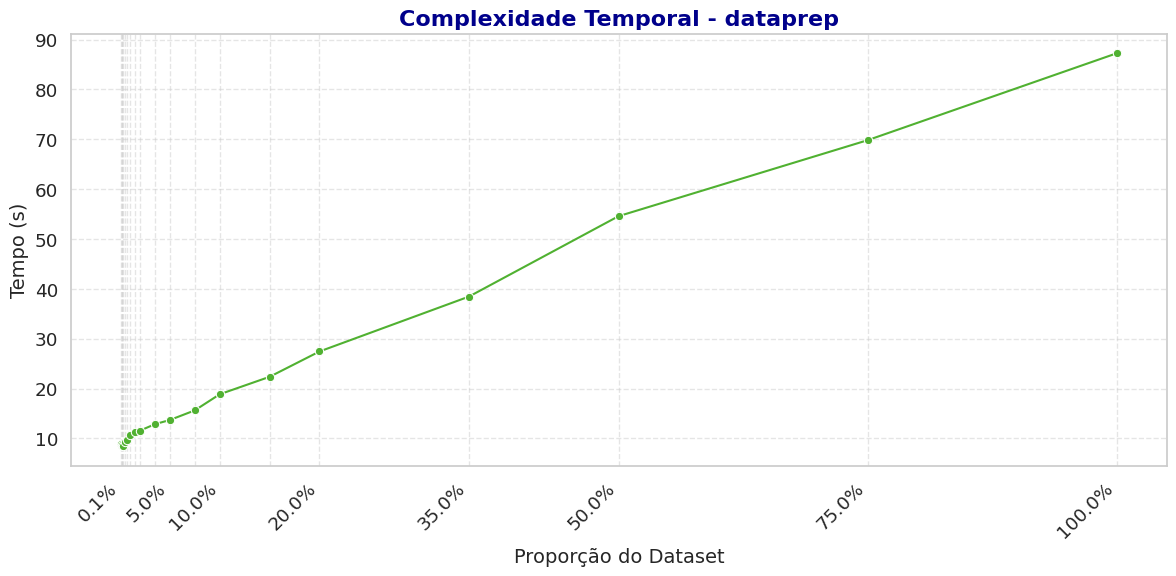

In [11]:
# Definir o estilo do seaborn
sns.set(style='whitegrid', palette='deep', font_scale=1.2)

# Cores diferentes para cada gráfico (opcional)
cores = sns.color_palette('husl', n_colors=len(time_pd.columns))

# Gerar ticks alternados até à quarta posição
xticks_labels = [
    f'{x*100:.1f}%' if (x*100) in [0.1, 5.0, 10.0, 20.0, 35.0, 50.0, 75.0, 100.0] else ''
    for x in time_pd.index
]

columnsWithallData = ['datajoining', 'eda', 'dataprep']

for i, coluna in enumerate(columnsWithallData):
    print(coluna)
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=time_pd.index, y=time_pd[coluna], marker='o', color=cores[i])
    plt.title(f'Complexidade Temporal - {coluna}', fontsize=16, weight='bold', color='darkblue')
    plt.xlabel('Proporção do Dataset', fontsize=14)
    plt.ylabel('Tempo (s)', fontsize=14)

    # Aplicar os xticks com espaços alternados no início
    plt.xticks(ticks=time_pd.index, labels=xticks_labels, rotation=45, ha='right')

    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

### B. Cluster Graph

In [14]:
time_pd[["UserDataSet", "clustering"]]

__index_level_0__,UserDataSet,clustering
0.0010,66504,5.100560
0.0015,97837,5.333444
0.0020,128330,5.695145
0.0030,185320,6.872297
0.0050,289040,8.352294
0.0070,382217,9.747213
0.0100,506490,11.696807
0.0150,683834,13.020688
0.0200,834416,15.361461
0.0350,1188598,17.008600


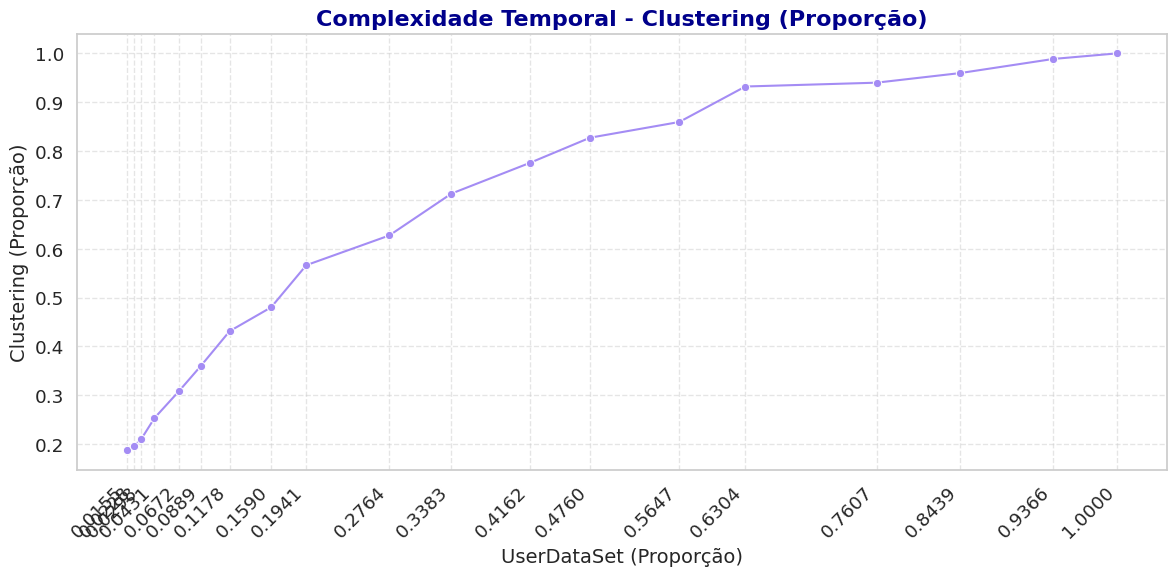

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter

# Definir o estilo do seaborn
sns.set(style='whitegrid', palette='deep', font_scale=1.2)

# Cores diferentes para o gráfico
cores = sns.color_palette('husl', n_colors=4)  # Criar a paleta com 4 cores

# Preparar os dados do eixo X (UserDataSet) e Y (clustering)
x = time_pd["UserDataSet"]
y = time_pd["clustering"]

# Calcular a proporção dos valores em relação ao valor máximo de cada eixo
x_prop = x / x.max()  # Proporção de UserDataSet
y_prop = y / y.max()  # Proporção de Clustering

# Criar o gráfico com as proporções
plt.figure(figsize=(12, 6))
sns.lineplot(x=x_prop, y=y_prop, marker='o', color=cores[3])  # Usar a quarta cor

# Adicionar título e rótulos aos eixos
plt.title('Complexidade Temporal - Clustering (Proporção)', fontsize=16, weight='bold', color='darkblue')
plt.xlabel('UserDataSet (Proporção)', fontsize=14)
plt.ylabel('Clustering (Proporção)', fontsize=14)

# Ajustar os xticks para garantir uma visualização limpa
xticks_labels = [f'{x * 100:.1f}%' for x in x_prop]  # Mostrar as proporções como porcentagem com uma casa decimal

# Definir os xticks com as labels
plt.xticks(ticks=x_prop, labels=xticks_labels, rotation=45, ha='right')

# Remover a notação científica nos eixos
plt.gca().yaxis.set_major_formatter(ScalarFormatter())  # Aplica o ScalarFormatter ao eixo Y
plt.gca().xaxis.set_major_formatter(ScalarFormatter())  # Aplica o ScalarFormatter ao eixo X

# Ajustar o layout e mostrar o gráfico
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### C. Gráfico com todas as fases juntas

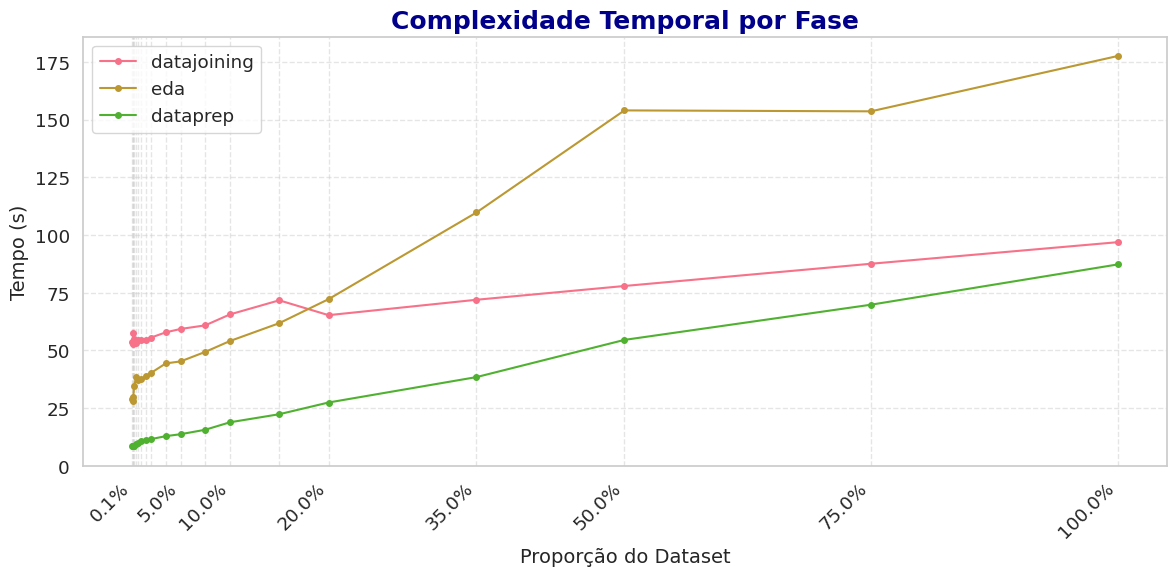

In [19]:
# Definir o estilo do seaborn
sns.set(style='whitegrid', palette='deep', font_scale=1.2)

# Cores diferentes para cada gráfico (opcional)
cores = sns.color_palette('husl', n_colors=len(time_pd.columns))

xticks_labels = [
    f'{x*100:.1f}%' if (x*100) in [0.1, 5.0, 10.0, 20.0, 35.0, 50.0, 75.0, 100.0] else ''
    for x in time_pd.index
]

# Plotando o gráfico com os ajustes
plt.figure(figsize=(12, 6))
for i, coluna in enumerate(columnsWithallData):
    plt.plot(time_pd.index, time_pd[coluna], marker='o', label=coluna, color=cores[i], markersize=4)

# Personalizando o gráfico
plt.title('Complexidade Temporal por Fase', fontsize=18, weight='bold', color='darkblue')
plt.xlabel('Proporção do Dataset', fontsize=14)
plt.ylabel('Tempo (s)', fontsize=14)

# Adicionando os xticks com espaços alternados
plt.xticks(ticks=time_pd.index, labels=xticks_labels, rotation=45, ha='right')

# Exibindo a legenda e a grade
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Exibindo o gráfico
plt.tight_layout()
plt.show()

### D. Gráfico com o tempo total (soma das fases)

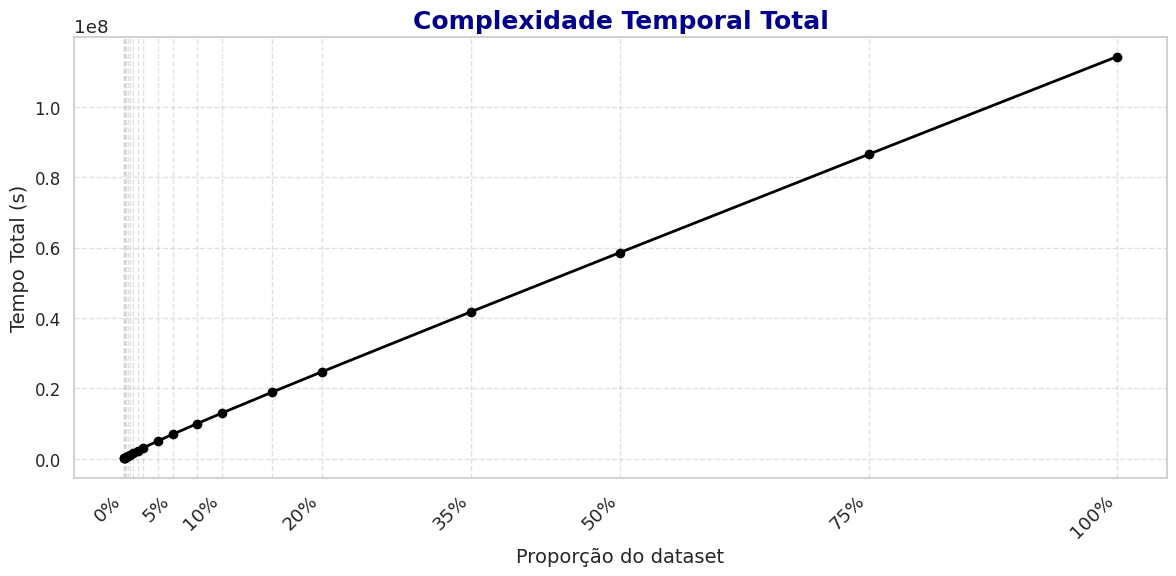

In [20]:
# Definir o estilo do seaborn
sns.set(style='whitegrid', palette='deep', font_scale=1.2)

# Calcular a soma total das colunas por linha
time_pd['total'] = time_pd.sum(axis=1)

# Plotando o gráfico com os ajustes
plt.figure(figsize=(12, 6))
plt.plot(time_pd.index, time_pd['total'], marker='o', color='black', markersize=6, linewidth=2, label='Total')

# Personalizando o gráfico
plt.title('Complexidade Temporal Total', fontsize=18, weight='bold', color='darkblue')
plt.xlabel('Proporção do dataset', fontsize=14)
plt.ylabel('Tempo Total (s)', fontsize=14)

# Melhorando os xticks para maior legibilidade
xticks_labels = [
    f'{x*100:.0f}%' if (x*100) in [0.1, 5.0, 10.0, 20.0, 35.0, 50.0, 75.0, 100.0] else ''
    for x in time_pd.index
]
plt.xticks(ticks=time_pd.index, labels=xticks_labels, rotation=45, ha='right')
plt.yticks(fontsize=12)

# Adicionando uma grade mais suave e destacando a linha
plt.grid(True, linestyle='--', alpha=0.6)

# Exibindo o gráfico
plt.tight_layout()
plt.show()

In [21]:
time_pd.to_parquet("dataComplexityFinal.parquet")